# Circos-Style Money Flow Chord Diagram

This notebook builds a self-contained Circos-style chord diagram from Accumulation Score time series in a local database.

Constraints honored:
- No project modules are imported or modified.
- Database access is read-only (SELECT-only).
- No files are written or mutated; all outputs are in-notebook only.

Quick usage:
- FLOW_PERIOD_DAYS = 1  # "today's move"
- FLOW_PERIOD_DAYS = 5  # "past 5 trading days"

Layer toggles:
- SHOW_ACCUM_FLOW / SHOW_LIT_FLOW / SHOW_SHORT_FLOW / SHOW_VOLUME_RING

Group toggles:
- ENABLED_GROUPS["MAG8"] = False to hide a group (recommended).
- You may comment out a group list, but then also set its ENABLED_GROUPS entry to False.


In [ ]:
# Ticker groups (hardcoded)
SECTOR_CORE_TICKERS = [
    "XLF","KRE","XLK","SMH","XLI","XLY","XLE","XLV","XLP","XLU"
]

GLOBAL_MACRO_TICKERS = [
    "SPY","QQQ","TQQQ","IWM","VGK","EWJ","EFA","EEM","FXI","UUP","TLT","GLD","USO","VIXY"
]

COMMODITIES_TICKERS = [
    "GLD","SLV","GDX","USO","UNG","URA"
]

MAG8_TICKERS = [
    "AAPL","MSFT","NVDA","AMZN","GOOGL","META","TSLA","AVGO"
]

ENABLED_GROUPS = {
    "GLOBAL_MACRO": True,
    "MAG8": True,
    "SECTOR_CORE": True,
    "COMMODITIES": True,
}

# Controls
END_DATE = None  # e.g., "2025-12-30"; None = auto-detect max date in DB
FLOW_PERIOD_DAYS = 5  # number of trading days to measure flow over
TOP_K_WINNERS = 8
TOP_K_LOSERS = 8
MIN_EDGE_FLOW = 0.0
DISTRIBUTION_MODE = "demand_weighted"  # "equal" or "demand_weighted"
STRAND_UNIT = 0.5  # controls link strand splitting density

# Layer toggles
SHOW_ACCUM_FLOW = True
SHOW_LIT_FLOW = True
SHOW_SHORT_FLOW = True
SHOW_VOLUME_RING = True
SHOW_TICKER_ARC = True


In [80]:
from pathlib import Path
from datetime import datetime, timedelta
import pandas as pd
import numpy as np

def find_db_candidates():
    root = Path('.').resolve()
    search_dirs = [
        root / 'data',
        root / 'darkpool_analysis' / 'data',
        root,
    ]
    patterns = ['*.duckdb', '*.db', '*.sqlite', '*.sqlite3']
    candidates = []
    for base in search_dirs:
        if not base.exists():
            continue
        for pattern in patterns:
            candidates.extend(list(base.rglob(pattern)))
    # Unique + files only
    unique = []
    seen = set()
    for p in candidates:
        if not p.is_file():
            continue
        if p in seen:
            continue
        seen.add(p)
        unique.append(p)
    unique.sort(key=lambda p: p.stat().st_mtime, reverse=True)
    return unique

def connect_db(db_path):
    db_path = Path(db_path)
    suffix = db_path.suffix.lower()
    errors = []

    def try_duckdb():
        import duckdb
        return duckdb.connect(database=str(db_path), read_only=True), 'duckdb'

    def try_sqlite():
        import sqlite3
        uri = f"file:{db_path.resolve().as_posix()}?mode=ro"
        return sqlite3.connect(uri, uri=True), 'sqlite'

    if suffix == '.duckdb':
        try:
            return try_duckdb()
        except Exception as e:
            errors.append(f'duckdb: {e}')
        try:
            return try_sqlite()
        except Exception as e:
            errors.append(f'sqlite: {e}')
    else:
        try:
            return try_sqlite()
        except Exception as e:
            errors.append(f'sqlite: {e}')
        try:
            return try_duckdb()
        except Exception as e:
            errors.append(f'duckdb: {e}')

    raise RuntimeError('Unable to open database. ' + '; '.join(errors))

def list_tables(conn, db_type):
    if db_type == 'duckdb':
        return [r[0] for r in conn.execute('SHOW TABLES').fetchall()]
    rows = conn.execute("SELECT name FROM sqlite_master WHERE type='table'").fetchall()
    return [r[0] for r in rows]

def get_columns(conn, db_type, table):
    pragma = f'PRAGMA table_info("{table}")'
    rows = conn.execute(pragma).fetchall()
    # rows: (cid, name, type, notnull, dflt_value, pk)
    return [r[1] for r in rows]

def normalize_name(name):
    return ''.join([c for c in name.lower() if c.isalnum()])

def pick_column(columns, candidates):
    norm_map = {normalize_name(c): c for c in columns}
    for cand in candidates:
        cand_norm = normalize_name(cand)
        if cand_norm in norm_map:
            return norm_map[cand_norm]
    for cand in candidates:
        cand_norm = normalize_name(cand)
        for col_norm, original in norm_map.items():
            if cand_norm in col_norm:
                return original
    return None

def quote_ident(name):
    safe = name.replace('"', '""')
    return f'"{safe}"'

TICKER_COL_CANDIDATES = ['ticker', 'symbol', 'sym']
DATE_COL_CANDIDATES = ['date', 'trade_date', 'market_date', 'dt', 'day']
ACCUM_COL_CANDIDATES = [
    'accumulation_score', 'accum_score', 'accumulation', 'accum',
    'accumulation_score_display', 'accum_score_display'
]

db_candidates = find_db_candidates()
print('DB candidates (newest first):')
for p in db_candidates:
    print(' -', p)

if not db_candidates:
    print('No database files found under ./data or ./darkpool_analysis/data.')
    raise SystemExit

DB_PATH = db_candidates[0]
print(f'Selected DB: {DB_PATH}')

conn, DB_TYPE = connect_db(DB_PATH)
print(f'Detected DB type: {DB_TYPE}')

tables = list_tables(conn, DB_TYPE)
print(f'Found {len(tables)} tables.')

scan_rows = []
for table in tables:
    try:
        cols = get_columns(conn, DB_TYPE, table)
    except Exception as e:
        scan_rows.append({
            'table': table,
            'ticker_col': None,
            'date_col': None,
            'accum_col': None,
            'row_count': None,
            'distinct_tickers': None,
            'error': str(e),
        })
        continue

    ticker_col = pick_column(cols, TICKER_COL_CANDIDATES)
    date_col = pick_column(cols, DATE_COL_CANDIDATES)
    accum_col = pick_column(cols, ACCUM_COL_CANDIDATES)

    row_count = None
    distinct_tickers = None
    if ticker_col and date_col and accum_col:
        try:
            row_count = conn.execute(
                f'SELECT COUNT(*) FROM {quote_ident(table)}'
            ).fetchone()[0]
            distinct_tickers = conn.execute(
                f'SELECT COUNT(DISTINCT {quote_ident(ticker_col)}) FROM {quote_ident(table)}'
            ).fetchone()[0]
        except Exception:
            pass

    scan_rows.append({
        'table': table,
        'ticker_col': ticker_col,
        'date_col': date_col,
        'accum_col': accum_col,
        'row_count': row_count,
        'distinct_tickers': distinct_tickers,
        'error': None,
    })

print('Scanned tables (ticker/date/accum detection):')
for row in scan_rows:
    print(
        f" - {row['table']}: ticker={row['ticker_col']} date={row['date_col']} accum={row['accum_col']} rows={row['row_count']} distinct_tickers={row['distinct_tickers']}"
    )

candidates = [r for r in scan_rows if r['ticker_col'] and r['date_col'] and r['accum_col']]
if not candidates:
    print('No tables matched the required ticker/date/accumulation schema.')
    conn.close()
    raise SystemExit

multi = [r for r in candidates if (r['distinct_tickers'] or 0) > 1]
pool = multi if multi else candidates
pool.sort(key=lambda r: (r['row_count'] or 0, r['distinct_tickers'] or 0), reverse=True)
best = pool[0]

SELECT_TABLE = best['table']
TICKER_COL = best['ticker_col']
DATE_COL = best['date_col']
ACCUM_COL = best['accum_col']

print('Selected table:')
print(f'  table={SELECT_TABLE}')
print(f'  ticker_col={TICKER_COL}, date_col={DATE_COL}, accum_col={ACCUM_COL}')

conn.close()


DB candidates (newest first):
 - C:\Users\fvign\Dropbox\Vscode\darkpool\darkpool_analysis\data\darkpool.duckdb
Selected DB: C:\Users\fvign\Dropbox\Vscode\darkpool\darkpool_analysis\data\darkpool.duckdb
Detected DB type: duckdb
Found 13 tables.
Scanned tables (ticker/date/accum detection):
 - composite_signal: ticker=symbol date=date accum=None rows=None distinct_tickers=None
 - daily_metrics: ticker=symbol date=date accum=accumulation_score rows=1241 distinct_tickers=39
 - finra_otc_weekly_raw: ticker=symbol date=week_start_date accum=None rows=None distinct_tickers=None
 - finra_short_daily_all_raw: ticker=symbol date=trade_date accum=None rows=None distinct_tickers=None
 - finra_short_daily_raw: ticker=symbol date=trade_date accum=None rows=None distinct_tickers=None
 - index_constituent_short_agg_daily: ticker=index_symbol date=trade_date accum=None rows=None distinct_tickers=None
 - lit_direction_daily: ticker=symbol date=date accum=None rows=None distinct_tickers=None
 - options_p

In [81]:
def build_ticker_universe():
    seen = set()
    ordered = []
    categories = {}
    enabled = globals().get("ENABLED_GROUPS", {})
    group_defs = [
        ("GLOBAL_MACRO", globals().get("GLOBAL_MACRO_TICKERS", [])),
        ("MAG8", globals().get("MAG8_TICKERS", [])),
        ("SECTOR_CORE", globals().get("SECTOR_CORE_TICKERS", [])),
        ("COMMODITIES", globals().get("COMMODITIES_TICKERS", [])),
    ]
    for group_name, tickers in group_defs:
        if not enabled.get(group_name, True):
            continue
        for t in tickers:
            if t not in seen:
                seen.add(t)
                ordered.append(t)
                categories[t] = group_name
    return ordered, categories


ticker_order, ticker_category = build_ticker_universe()
ticker_list = [t.upper() for t in ticker_order]

conn, DB_TYPE = connect_db(DB_PATH)

if DB_TYPE == 'duckdb':
    date_expr = f"CAST({quote_ident(DATE_COL)} AS DATE)"
    accum_expr = f"TRY_CAST({quote_ident(ACCUM_COL)} AS DOUBLE)"
else:
    date_expr = f"DATE({quote_ident(DATE_COL)})"
    accum_expr = f"CAST({quote_ident(ACCUM_COL)} AS REAL)"

placeholders = ','.join(['?'] * len(ticker_list))
query = (
    f"SELECT UPPER({quote_ident(TICKER_COL)}) AS ticker, "
    f"{date_expr} AS date, {accum_expr} AS accumulation_score "
    f"FROM {quote_ident(SELECT_TABLE)} "
    f"WHERE UPPER({quote_ident(TICKER_COL)}) IN ({placeholders})"
)

try:
    if DB_TYPE == 'duckdb':
        df_raw = conn.execute(query, ticker_list).df()
    else:
        df_raw = pd.read_sql_query(query, conn, params=ticker_list)
finally:
    conn.close()

if df_raw.empty:
    print('No data returned for the specified tickers.')
    raise SystemExit

df_raw['date'] = pd.to_datetime(df_raw['date'], errors='coerce').dt.date
df_raw['ticker'] = df_raw['ticker'].str.upper()
df_raw['accumulation_score'] = pd.to_numeric(df_raw['accumulation_score'], errors='coerce')
df_raw = df_raw.dropna(subset=['date', 'accumulation_score'])

if df_raw.empty:
    print('All accumulation score rows are null after parsing.')
    raise SystemExit

max_date = df_raw['date'].max()
if END_DATE is None or str(END_DATE).strip() == '':
    END_DATE_RESOLVED = max_date
else:
    END_DATE_RESOLVED = pd.to_datetime(END_DATE).date()
    if END_DATE_RESOLVED > max_date:
        print(f'END_DATE {END_DATE_RESOLVED} exceeds DB max date {max_date}; using max date.')
        END_DATE_RESOLVED = max_date

flow_days = int(FLOW_PERIOD_DAYS) if FLOW_PERIOD_DAYS and int(FLOW_PERIOD_DAYS) > 0 else 1


def tail_n(df_ticker, n, end_date):
    df = df_ticker[df_ticker['date'] <= end_date].sort_values('date')
    if df.empty:
        return df
    return df.tail(n)


rows = []
for ticker in ticker_order:
    df_t = df_raw[df_raw['ticker'] == ticker]
    tail = tail_n(df_t, flow_days, END_DATE_RESOLVED)
    if len(tail) < 2:
        a_start = None
        a_end = None
    else:
        a_start = float(tail['accumulation_score'].iloc[0])
        a_end = float(tail['accumulation_score'].iloc[-1])
    rows.append({
        'ticker': ticker,
        'category': ticker_category.get(ticker, 'UNKNOWN'),
        'A_end': a_end,
        'A_start': a_start,
        'end_date': END_DATE_RESOLVED,
        'start_date': tail['date'].iloc[0] if len(tail) else None,
        'samples': len(tail),
    })

df_scores = pd.DataFrame(rows)

# --- Volume data discovery (lit/short buy/sell) ---
LIT_BUY_CANDIDATES = ['lit_buy_volume', 'lit_buy_vol', 'lit_buy']
LIT_SELL_CANDIDATES = ['lit_sell_volume', 'lit_sell_vol', 'lit_sell']
SHORT_BUY_CANDIDATES = ['short_buy_volume', 'short_buy_vol', 'short_buy']
SHORT_SELL_CANDIDATES = ['short_sell_volume', 'short_sell_vol', 'short_sell']


def find_volume_table(conn, db_type):
    tables = list_tables(conn, db_type)
    candidates = []
    for table in tables:
        try:
            cols = get_columns(conn, db_type, table)
        except Exception:
            continue
        ticker_col = pick_column(cols, TICKER_COL_CANDIDATES)
        date_col = pick_column(cols, DATE_COL_CANDIDATES)
        lit_buy_col = pick_column(cols, LIT_BUY_CANDIDATES)
        lit_sell_col = pick_column(cols, LIT_SELL_CANDIDATES)
        short_buy_col = pick_column(cols, SHORT_BUY_CANDIDATES)
        short_sell_col = pick_column(cols, SHORT_SELL_CANDIDATES)
        if not (ticker_col and date_col and lit_buy_col and lit_sell_col and short_buy_col and short_sell_col):
            continue
        row_count = None
        distinct_tickers = None
        try:
            row_count = conn.execute(
                f'SELECT COUNT(*) FROM {quote_ident(table)}'
            ).fetchone()[0]
            distinct_tickers = conn.execute(
                f'SELECT COUNT(DISTINCT {quote_ident(ticker_col)}) FROM {quote_ident(table)}'
            ).fetchone()[0]
        except Exception:
            pass
        candidates.append({
            'table': table,
            'ticker_col': ticker_col,
            'date_col': date_col,
            'lit_buy_col': lit_buy_col,
            'lit_sell_col': lit_sell_col,
            'short_buy_col': short_buy_col,
            'short_sell_col': short_sell_col,
            'row_count': row_count,
            'distinct_tickers': distinct_tickers,
        })
    if not candidates:
        return None
    candidates.sort(key=lambda r: (r['row_count'] or 0, r['distinct_tickers'] or 0), reverse=True)
    return candidates[0]


conn, DB_TYPE = connect_db(DB_PATH)
try:
    volume_info = find_volume_table(conn, DB_TYPE)
finally:
    conn.close()

VOLUME_DATA_AVAILABLE = volume_info is not None

if VOLUME_DATA_AVAILABLE:
    conn, DB_TYPE = connect_db(DB_PATH)
    try:
        if DB_TYPE == 'duckdb':
            date_expr = f"CAST({quote_ident(volume_info['date_col'])} AS DATE)"
            num_cast = "TRY_CAST"
        else:
            date_expr = f"DATE({quote_ident(volume_info['date_col'])})"
            num_cast = "CAST"

        query = (
            f"SELECT UPPER({quote_ident(volume_info['ticker_col'])}) AS ticker, "
            f"{date_expr} AS date, "
            f"{num_cast}({quote_ident(volume_info['lit_buy_col'])} AS DOUBLE) AS lit_buy, "
            f"{num_cast}({quote_ident(volume_info['lit_sell_col'])} AS DOUBLE) AS lit_sell, "
            f"{num_cast}({quote_ident(volume_info['short_buy_col'])} AS DOUBLE) AS short_buy, "
            f"{num_cast}({quote_ident(volume_info['short_sell_col'])} AS DOUBLE) AS short_sell "
            f"FROM {quote_ident(volume_info['table'])} "
            f"WHERE UPPER({quote_ident(volume_info['ticker_col'])}) IN ({placeholders})"
        )

        if DB_TYPE == 'duckdb':
            df_vol_raw = conn.execute(query, ticker_list).df()
        else:
            df_vol_raw = pd.read_sql_query(query, conn, params=ticker_list)
    finally:
        conn.close()

    df_vol_raw['date'] = pd.to_datetime(df_vol_raw['date'], errors='coerce').dt.date
    df_vol_raw['ticker'] = df_vol_raw['ticker'].str.upper()
    for col in ['lit_buy', 'lit_sell', 'short_buy', 'short_sell']:
        df_vol_raw[col] = pd.to_numeric(df_vol_raw[col], errors='coerce')
    df_vol_raw = df_vol_raw.dropna(subset=['date'])

    vol_rows = []
    for ticker in ticker_order:
        df_t = df_vol_raw[df_vol_raw['ticker'] == ticker]
        tail = tail_n(df_t, flow_days, END_DATE_RESOLVED)
        if tail.empty:
            vol_rows.append({
                'ticker': ticker,
                'lit_buy_sum': None,
                'lit_sell_sum': None,
                'short_buy_sum': None,
                'short_sell_sum': None,
                'volume_samples': 0,
            })
            continue
        vol_rows.append({
            'ticker': ticker,
            'lit_buy_sum': float(tail['lit_buy'].sum(skipna=True)),
            'lit_sell_sum': float(tail['lit_sell'].sum(skipna=True)),
            'short_buy_sum': float(tail['short_buy'].sum(skipna=True)),
            'short_sell_sum': float(tail['short_sell'].sum(skipna=True)),
            'volume_samples': len(tail),
        })

    df_volume = pd.DataFrame(vol_rows)
else:
    df_volume = pd.DataFrame(columns=[
        'ticker', 'lit_buy_sum', 'lit_sell_sum', 'short_buy_sum', 'short_sell_sum', 'volume_samples'
    ])


In [82]:
def build_edges_from_value(df, value_col, top_k_winners, top_k_losers):
    df = df[['ticker', value_col]].dropna().copy()
    winners = df[df[value_col] > 0].nlargest(top_k_winners, value_col)
    losers = df[df[value_col] < 0].copy()
    losers['supply'] = -losers[value_col]
    losers = losers.nlargest(top_k_losers, 'supply')

    edges = []
    total_demand = winners[value_col].sum() if not winners.empty else 0.0
    total_supply = losers['supply'].sum() if not losers.empty else 0.0

    if winners.empty or losers.empty:
        return pd.DataFrame(edges), winners, losers, total_demand, total_supply

    if DISTRIBUTION_MODE not in {'equal', 'demand_weighted'}:
        raise ValueError('DISTRIBUTION_MODE must be "equal" or "demand_weighted"')

    if DISTRIBUTION_MODE == 'equal':
        for _, loser in losers.iterrows():
            flow_each = loser['supply'] / len(winners)
            for _, winner in winners.iterrows():
                if flow_each >= MIN_EDGE_FLOW:
                    edges.append({
                        'source': loser['ticker'],
                        'dest': winner['ticker'],
                        'flow': float(flow_each),
                    })
    else:
        if total_demand > 0:
            for _, loser in losers.iterrows():
                for _, winner in winners.iterrows():
                    flow = loser['supply'] * (winner[value_col] / total_demand)
                    if flow >= MIN_EDGE_FLOW:
                        edges.append({
                            'source': loser['ticker'],
                            'dest': winner['ticker'],
                            'flow': float(flow),
                        })

    edges_df = pd.DataFrame(edges)
    if not edges_df.empty:
        edges_df = edges_df.sort_values('flow', ascending=False).reset_index(drop=True)
    return edges_df, winners, losers, total_demand, total_supply


def split_strands(edges_df):
    strand_rows = []
    unit = STRAND_UNIT if STRAND_UNIT and STRAND_UNIT > 0 else None
    for _, row in edges_df.iterrows():
        flow = row['flow']
        if unit:
            n = max(1, int(np.floor(flow / unit)))
        else:
            n = 1
        weight = flow / n
        for _ in range(n):
            strand_rows.append({
                'source': row['source'],
                'dest': row['dest'],
                'weight': weight,
            })
    return pd.DataFrame(strand_rows)


# Accumulation flow
if df_scores['A_end'].notna().any() and df_scores['A_start'].notna().any():
    df_scores['delta'] = df_scores['A_end'] - df_scores['A_start']
else:
    df_scores['delta'] = np.nan

df_scores['role'] = np.where(
    df_scores['delta'] > 0,
    'winner',
    np.where(df_scores['delta'] < 0, 'loser', 'neutral')
)

df_scores_sorted = df_scores.sort_values(
    by='delta', key=lambda s: s.abs(), ascending=False
).reset_index(drop=True)

accum_edges_df, accum_winners, accum_losers, accum_demand, accum_supply = build_edges_from_value(
    df_scores, 'delta', TOP_K_WINNERS, TOP_K_LOSERS
)
accum_strands_df = split_strands(accum_edges_df)

# Lit and Short flows (net buy - sell)
if VOLUME_DATA_AVAILABLE and not df_volume.empty:
    df_volume = df_volume.copy()
    df_volume['lit_net'] = df_volume['lit_buy_sum'] - df_volume['lit_sell_sum']
    df_volume['short_net'] = df_volume['short_buy_sum'] - df_volume['short_sell_sum']

    lit_edges_df, lit_winners, lit_losers, lit_demand, lit_supply = build_edges_from_value(
        df_volume, 'lit_net', TOP_K_WINNERS, TOP_K_LOSERS
    )
    short_edges_df, short_winners, short_losers, short_demand, short_supply = build_edges_from_value(
        df_volume, 'short_net', TOP_K_WINNERS, TOP_K_LOSERS
    )

    lit_strands_df = split_strands(lit_edges_df)
    short_strands_df = split_strands(short_edges_df)
else:
    lit_edges_df = pd.DataFrame()
    short_edges_df = pd.DataFrame()
    lit_strands_df = pd.DataFrame()
    short_strands_df = pd.DataFrame()
    lit_winners = pd.DataFrame()
    short_winners = pd.DataFrame()
    lit_losers = pd.DataFrame()
    short_losers = pd.DataFrame()
    lit_demand = lit_supply = 0.0
    short_demand = short_supply = 0.0


In [83]:
display(df_scores_sorted[['ticker', 'category', 'A_end', 'A_start', 'delta', 'role']])

if SHOW_ACCUM_FLOW:
    if accum_edges_df.empty:
        display(pd.DataFrame(columns=['source', 'dest', 'flow']))
    else:
        display(accum_edges_df[['source', 'dest', 'flow']])

if VOLUME_DATA_AVAILABLE and not df_volume.empty:
    display(df_volume[['ticker', 'lit_buy_sum', 'lit_sell_sum', 'short_buy_sum', 'short_sell_sum']])
else:
    print('Volume data not available for lit/short buy/sell flows.')

summary_parts = [
    f'END_DATE={END_DATE_RESOLVED}',
    f'FLOW_PERIOD_DAYS={FLOW_PERIOD_DAYS}',
    f'accum_supply={accum_supply:.2f}',
    f'accum_demand={accum_demand:.2f}',
]
if SHOW_LIT_FLOW:
    summary_parts.append(f'lit_supply={lit_supply:.2f}')
    summary_parts.append(f'lit_demand={lit_demand:.2f}')
if SHOW_SHORT_FLOW:
    summary_parts.append(f'short_supply={short_supply:.2f}')
    summary_parts.append(f'short_demand={short_demand:.2f}')

summary_parts.append(f'accum_edges={len(accum_edges_df)}')
summary_parts.append(f'lit_edges={len(lit_edges_df)}')
summary_parts.append(f'short_edges={len(short_edges_df)}')
summary_parts.append(
    f'strands={len(accum_strands_df) + len(lit_strands_df) + len(short_strands_df)}'
)

print(' | '.join(summary_parts))


,ticker,category,A_end,A_start,delta,role
0,URA,COMMODITIES,-0.133825,0.244315,-0.378140,loser
1,QQQ,GLOBAL_MACRO,0.181990,-0.177174,0.359164,winner
2,XLI,SECTOR_CORE,-0.157091,0.188495,-0.345586,loser
3,VIXY,GLOBAL_MACRO,0.039932,-0.290606,0.330538,winner
4,UNG,COMMODITIES,-0.087524,0.228725,-0.316249,loser
5,EWJ,GLOBAL_MACRO,-0.053555,0.261510,-0.315065,loser
6,XLP,SECTOR_CORE,-0.046603,0.262498,-0.309101,loser
7,VGK,GLOBAL_MACRO,-0.126486,-0.434152,0.307665,winner
8,XLU,SECTOR_CORE,-0.214453,0.064733,-0.279185,loser
9,IWM,GLOBAL_MACRO,-0.334071,-0.081465,-0.252606,loser


,source,dest,flow
0,URA,QQQ,0.075780
1,URA,VIXY,0.069740
2,XLI,QQQ,0.069256
3,URA,VGK,0.064914
4,XLI,VIXY,0.063736
...,...,...,...
59,IWM,XLV,0.014599
60,IWM,USO,0.014230
61,GDX,FXI,0.008229
62,GDX,XLV,0.008096


END_DATE=2025-12-30, WINDOW_DAYS=10 | total_supply=2.34, total_demand=1.79 | winners=8, losers=8, edges=64, strands=64


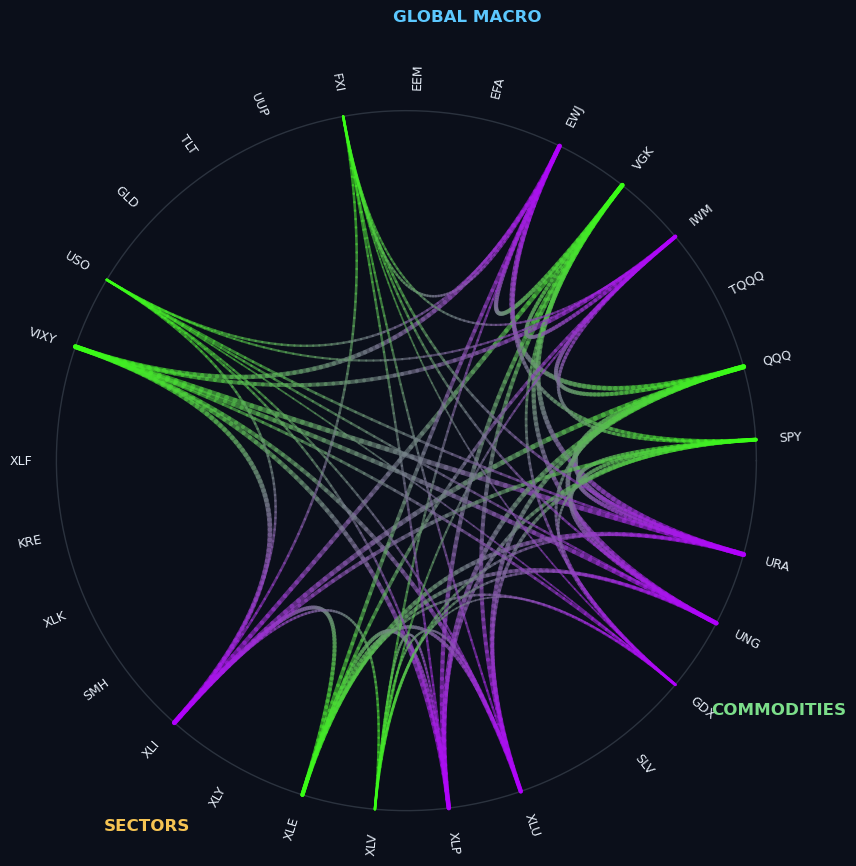

In [84]:
import math
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import to_rgba
from matplotlib.patches import Wedge

CATEGORY_LABELS = {
    'GLOBAL_MACRO': 'GLOBAL MACRO',
    'MAG8': 'MAG8',
    'SECTOR_CORE': 'SECTORS',
    'COMMODITIES': 'COMMODITIES',
}
CATEGORY_PALETTE = {
    'GLOBAL_MACRO': '#5CC8FF',
    'MAG8': '#DDA0FF',
    'SECTOR_CORE': '#F6C453',
    'COMMODITIES': '#7CDE8A',
    'UNKNOWN': '#A0A0A0',
}

FLOW_ACCUM_SOURCE = '#B300FF'  # neon purple
FLOW_ACCUM_DEST = '#39FF14'    # neon green

FLOW_LIT_SELL = '#FF7A7A'
FLOW_LIT_BUY = '#7AD0FF'
FLOW_SHORT_SELL = '#C1121F'
FLOW_SHORT_BUY = '#1D4ED8'

RING_LIT_BUY = '#8BD3FF'
RING_LIT_SELL = '#FF9AA2'
RING_SHORT_BUY = '#3B82F6'
RING_SHORT_SELL = '#EF4444'


def add_gradient_curve(ax, points, color_start, color_end, lw, alpha):
    if len(points) < 2:
        return
    segments = np.stack([points[:-1], points[1:]], axis=1)
    c0 = np.array(to_rgba(color_start))
    c1 = np.array(to_rgba(color_end))
    t = np.linspace(0, 1, len(segments))[:, None]
    colors = c0 * (1 - t) + c1 * t
    colors[:, 3] = colors[:, 3] * alpha
    lc = LineCollection(segments, colors=colors, linewidths=lw, capstyle='round')
    ax.add_collection(lc)


def draw_band(ax, start_deg, end_deg, inner_r, outer_r, color, alpha):
    if alpha <= 0:
        return
    wedge = Wedge(
        (0, 0), outer_r, start_deg, end_deg,
        width=outer_r - inner_r,
        facecolor=color,
        edgecolor='none',
        alpha=alpha,
    )
    ax.add_patch(wedge)


def plot_chord_matplotlib():
    grouped = {
        'GLOBAL_MACRO': [t for t in ticker_order if ticker_category.get(t) == 'GLOBAL_MACRO'],
        'MAG8': [t for t in ticker_order if ticker_category.get(t) == 'MAG8'],
        'SECTOR_CORE': [t for t in ticker_order if ticker_category.get(t) == 'SECTOR_CORE'],
        'COMMODITIES': [t for t in ticker_order if ticker_category.get(t) == 'COMMODITIES'],
    }

    total_nodes = sum(len(v) for v in grouped.values())
    if total_nodes == 0:
        print('No nodes to plot.')
        return

    gap = 0.12
    total_gap = gap * len([g for g in grouped.values() if g])
    usable = 2 * math.pi - total_gap
    if usable <= 0:
        usable = 2 * math.pi
    step = usable / total_nodes
    arc_span = step * 0.85

    angles = {}
    spans = {}
    angle = 0.0
    for cat in ['GLOBAL_MACRO', 'MAG8', 'SECTOR_CORE', 'COMMODITIES']:
        if not grouped[cat]:
            continue
        angle += gap / 2
        for t in grouped[cat]:
            angles[t] = angle
            spans[t] = (angle - arc_span / 2, angle + arc_span / 2)
            angle += step
        angle += gap / 2

    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'aspect': 'equal'})
    fig.patch.set_facecolor('#0b0f1a')
    ax.set_facecolor('#0b0f1a')
    ax.axis('off')

    # Base circle
    theta = np.linspace(0, 2 * math.pi, 400)
    ax.plot(np.cos(theta), np.sin(theta), color='#39424e', lw=1.0, alpha=0.6)

    # Ticker arcs
    if SHOW_TICKER_ARC:
        base_outer = 1.05
        base_width = 0.08
        for t, (a0, a1) in spans.items():
            start_deg = math.degrees(a0)
            end_deg = math.degrees(a1)
            color = CATEGORY_PALETTE.get(ticker_category.get(t, 'UNKNOWN'), '#A0A0A0')
            wedge = Wedge(
                (0, 0), base_outer, start_deg, end_deg,
                width=base_width,
                facecolor=color,
                edgecolor='#222831',
                lw=0.4,
                alpha=0.9,
            )
            ax.add_patch(wedge)
    else:
        base_outer = 1.02
        base_width = 0.02

    # Volume rings
    if SHOW_VOLUME_RING and VOLUME_DATA_AVAILABLE and not df_volume.empty:
        band_width = 0.035
        band_gap = 0.01
        band_start = base_outer + band_gap
        bands = [
            ('lit_buy_sum', RING_LIT_BUY),
            ('lit_sell_sum', RING_LIT_SELL),
            ('short_buy_sum', RING_SHORT_BUY),
            ('short_sell_sum', RING_SHORT_SELL),
        ]
        max_vals = {}
        for col, _ in bands:
            series = pd.to_numeric(df_volume[col], errors='coerce')
            max_vals[col] = float(series.max()) if series.notna().any() else 0.0

        for idx, (col, color) in enumerate(bands):
            inner_r = band_start + idx * (band_width + band_gap)
            outer_r = inner_r + band_width
            for t, (a0, a1) in spans.items():
                value = df_volume.loc[df_volume['ticker'] == t, col]
                if value.empty or pd.isna(value.iloc[0]):
                    continue
                max_val = max_vals.get(col, 0.0)
                alpha = 0.15 + 0.85 * (float(value.iloc[0]) / max_val) if max_val > 0 else 0.0
                draw_band(
                    ax,
                    math.degrees(a0),
                    math.degrees(a1),
                    inner_r,
                    outer_r,
                    color,
                    alpha,
                )

    # Chords
    def draw_chords(strands_df, color_start, color_end, alpha=0.6):
        if strands_df.empty:
            return
        max_w = strands_df['weight'].max() if not strands_df.empty else 1.0
        for _, row in strands_df.iterrows():
            src = row['source']
            dst = row['dest']
            w = row['weight']
            if src not in angles or dst not in angles:
                continue
            a0 = angles[src]
            a1 = angles[dst]
            p0 = np.array([math.cos(a0), math.sin(a0)])
            p2 = np.array([math.cos(a1), math.sin(a1)])
            p1 = np.array([0.0, 0.0])
            t = np.linspace(0, 1, 80)[:, None]
            curve = (1 - t) ** 2 * p0 + 2 * (1 - t) * t * p1 + t ** 2 * p2
            lw = 0.6 + 3.2 * ((w / max_w) ** 0.7)
            add_gradient_curve(ax, curve, color_start, color_end, lw=lw, alpha=alpha)

    if SHOW_LIT_FLOW:
        draw_chords(lit_strands_df, FLOW_LIT_SELL, FLOW_LIT_BUY, alpha=0.5)
    if SHOW_SHORT_FLOW:
        draw_chords(short_strands_df, FLOW_SHORT_SELL, FLOW_SHORT_BUY, alpha=0.55)
    if SHOW_ACCUM_FLOW:
        draw_chords(accum_strands_df, FLOW_ACCUM_SOURCE, FLOW_ACCUM_DEST, alpha=0.6)

    # Ticker labels
    for t, ang in angles.items():
        x = math.cos(ang)
        y = math.sin(ang)
        r = 1.18
        rot = math.degrees(ang)
        if math.pi / 2 < ang < 3 * math.pi / 2:
            rot += 180
        ax.text(
            r * x, r * y, t,
            color='#E6EDF7', fontsize=9,
            ha='center', va='center',
            rotation=rot, rotation_mode='anchor'
        )

    # Category labels
    for cat, tickers in grouped.items():
        if not tickers:
            continue
        mid_angle = np.mean([angles[t] for t in tickers])
        ax.text(
            1.35 * math.cos(mid_angle),
            1.35 * math.sin(mid_angle),
            CATEGORY_LABELS.get(cat, cat),
            color=CATEGORY_PALETTE.get(cat, '#A0A0A0'),
            fontsize=12, fontweight='bold',
            ha='center', va='center'
        )

    plt.show()


plot_chord_matplotlib()
